<a href="https://colab.research.google.com/github/jland123/Confocal_Image_counter/blob/main/Public_Cell_Counter_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2025 Jakob Landa

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

If you use this code in your research, please cite:
Jakob Landa. (2025). Public Cell Counter AI.ipynb. https://colab.research.google.com/drive/1EeibgM49BOs1z61m8sRYPLOZMg5Q_0th#scrollTo=TkyT88ACDlFV.


THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

**Connect Drive**

(blocks of code can be run by clicking the play button on the top left)

In [2]:
  from google.colab import drive
  drive.mount('/content/drive')



Mounted at /content/drive


**Detector**

Scroll down to the bottom of the code block after running the cell in order to input the filepaths and parameters

The Model is in the same folder as this ipynb was

Note: the first time running the detector takes slightly longer  due to installations


File Paths can be found by

1) clicking on the folder icon on the left

2) navigating to the desired file/folder

3) clicking the three dots when you mouse over the desired file/folder

4) clicking "copy path:

an error will occur if any filepath is incorrect and the code will not run


Please enter the path to the model (.h5 file)/content/drive/MyDrive/Public AI detector/cell_count_model_v6.h5
Color to test (red / green / blue / yellow / other): yellow
Custom brightness threshold (0-255)? (press enter for default): 
Custom pixel area threshold? (press enter for default): 
Display images as they are detected? (y/n): y
Path to red image folder: /content/drive/MyDrive/image test/red_unzipped
Path to green image folder: /content/drive/MyDrive/image test/green_unzipped

--- AI Cell Count Predictions ---

z1_Maximumintensityprojection.tif (red).tif + z1_Maximumintensityprojection.tif (green).tif: Predicted Cell Count = 586


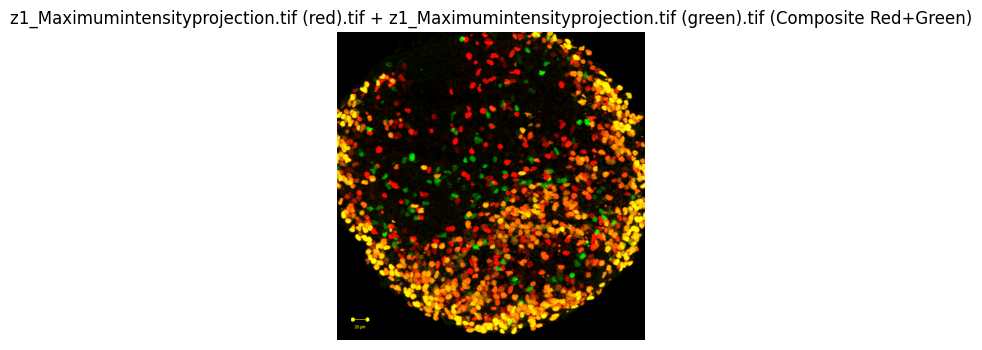

z2_Maximumintensityprojection.tif (red).tif + z2_Maximumintensityprojection.tif (green).tif: Predicted Cell Count = 931


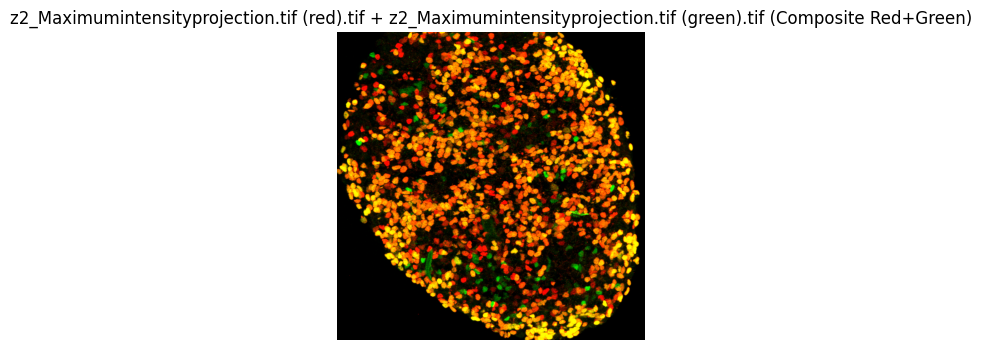

z3_Maximumintensityprojection.tif (red).tif + z3_Maximumintensityprojection.tif (green).tif: Predicted Cell Count = 424


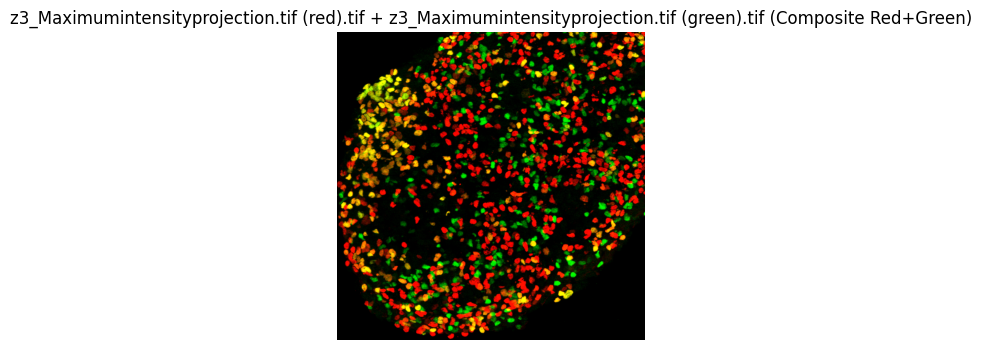

z4_Maximum intensity projection.tif (red).tif + z4_Maximum intensity projection.tif (green).tif: Predicted Cell Count = 439


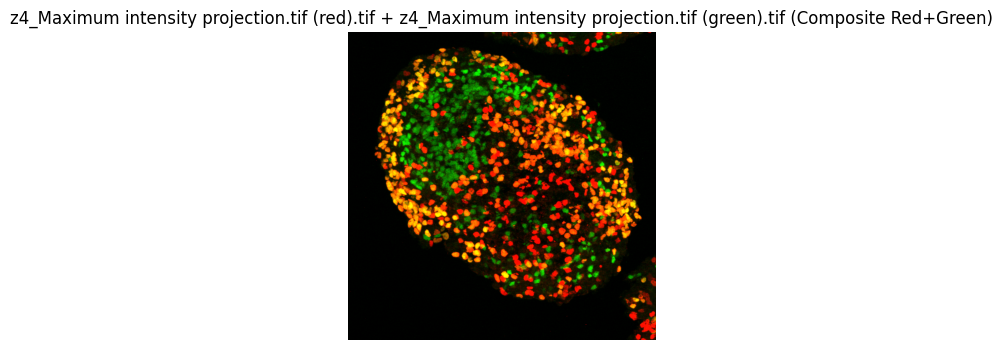

z5_Maximumintensityprojection.tif (red).tif + z5_Maximumintensityprojection.tif (green).tif: Predicted Cell Count = 475


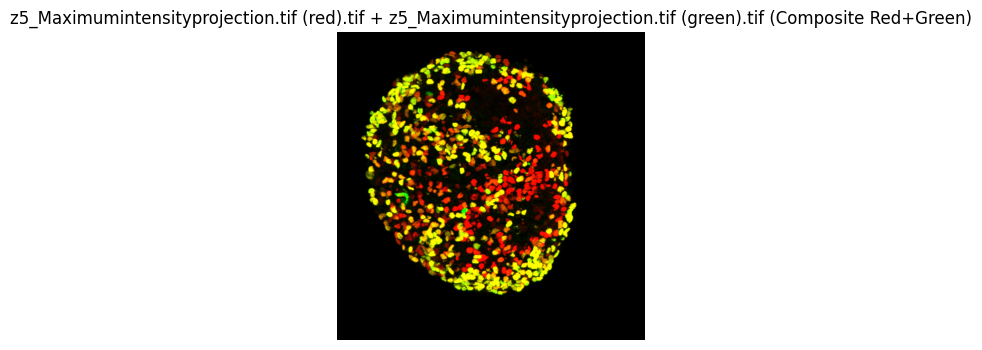

z6_Maximumintensityprojection.tif (red).tif + z6_Maximumintensityprojection.tif (green).tif: Predicted Cell Count = 358


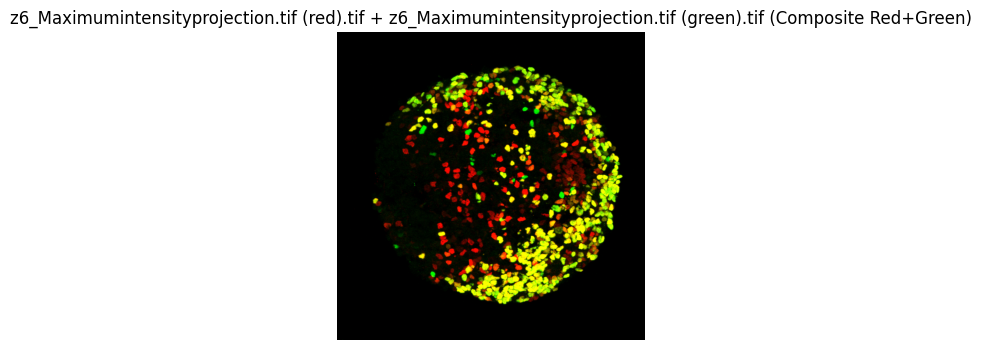


Results saved to: cell_count_predictions.csv


In [3]:
import os
try:
    import cv2
except ImportError:
    !pip install --quiet opencv-python-headless
    import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


model_path = input("Please enter the path to the model (.h5 file)")
model = tf.keras.models.load_model(model_path, compile=False)

def remove_small_components(binary_img, min_area):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    filtered = np.zeros_like(binary_img)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered[labels == i] = 255
    return filtered

color = input("Color to test (red / green / blue / yellow / other): ").strip().lower()
custom_thresh = input("Custom brightness threshold (0-255)? (press enter for default): ").strip()
custom_area = input("Custom pixel area threshold? (press enter for default): ").strip()
Display = input("Display images as they are detected? (y/n): ").strip().lower() == 'y'


default_thresholds = {'red': 60, 'green': 40, 'blue': 20, 'other': 40}
threshold = default_thresholds.get(color, 40)
min_area = 25

if custom_thresh:
    threshold = int(custom_thresh)
if custom_area:
    min_area = int(custom_area)


if color == 'yellow':
    folder_r = input("Path to red image folder: ").strip()
    folder_g = input("Path to green image folder: ").strip()
else:
    folder = input(f"Path to images folder: ").strip()

print("\n--- AI Cell Count Predictions ---\n")


results = []

if color == 'yellow':
    red_files = sorted([f for f in os.listdir(folder_r) if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
    green_files = sorted([f for f in os.listdir(folder_g) if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
    num_pairs = min(len(red_files), len(green_files))
    paired_files = list(zip(red_files[:num_pairs], green_files[:num_pairs]))

    for fname_r, fname_g in paired_files:
        img_r = np.array(Image.open(os.path.join(folder_r, fname_r)).convert('L'))
        img_g = np.array(Image.open(os.path.join(folder_g, fname_g)).convert('L'))

        img_r = cv2.resize(img_r, (610, 610))
        img_g = cv2.resize(img_g, (610, 610))

        binary_r = (img_r > default_thresholds['red']).astype(np.uint8) * 255
        binary_g = (img_g > default_thresholds['green']).astype(np.uint8) * 255

        binary_r = remove_small_components(binary_r, min_area)
        binary_g = remove_small_components(binary_g, min_area)

        combined = np.logical_and(binary_r == 255, binary_g == 255).astype(np.uint8) * 255
        final_img = combined

        img_input = final_img / 255.0
        img_input = np.expand_dims(img_input, axis=(0, -1))

        prediction = model.predict(img_input, verbose=0)[0][0]
        count = int(round(prediction))

        print(f"{fname_r} + {fname_g}: Predicted Cell Count = {count}")
        results.append({
            'File 1': fname_r,
            'File 2': fname_g,
            'Color': 'yellow',
            'Predicted Count': count
        })

        if Display:
            composite = np.stack([img_r, img_g, np.zeros_like(img_r)], axis=-1)
            plt.figure(figsize=(4, 4))
            plt.imshow(composite)
            plt.title(f"{fname_r} + {fname_g} (Composite Red+Green)")
            plt.axis('off')
            plt.show()

else:
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])

    for fname in files:
        img = np.array(Image.open(os.path.join(folder, fname)).convert('L'))
        img = cv2.resize(img, (610, 610))

        binary = (img > threshold).astype(np.uint8) * 255
        filtered = remove_small_components(binary, min_area)
        final_img = filtered

        img_input = final_img / 255.0
        img_input = np.expand_dims(img_input, axis=(0, -1))

        prediction = model.predict(img_input, verbose=0)[0][0]
        count = int(round(prediction))

        print(f"{fname}: Predicted Cell Count = {count}")
        results.append({
            'File': fname,
            'Color': color,
            'Predicted Count': count
        })

        if Display:
            plt.figure(figsize=(4, 4))
            plt.imshow(img_input.squeeze(), cmap='gray')
            plt.title(f"{fname} ({color})")
            plt.axis('off')
            plt.show()


df = pd.DataFrame(results)
csv_path = 'cell_count_predictions.csv'
df.to_csv(csv_path, index=False)
print(f"\nResults saved to: {csv_path}")